# **FINAL DEEP LEARNING**  
## **NO. 2**

Sherly Vaneza  
2702222163

# LINK YOUTUBE: https://youtu.be/lNg_T_a4cMY

# Sebagai data scientist anda mendapat tantangan untuk menyelesaikan masalah data image yang memiliki noise. Anda perlu membangun model deep learning yang mampu membersihkan data image yang mengandung noise menjadi data yang bersih tanpa noise. Namun sayangnya anda tidak memiliki data yang mengandung noise dengan cukup, sehingga anda perlu membuat image data dengan memberikan noise nilai acak yang diambil dari distribusi normal (Gaussian), menggunakan rata-rata 0.0 dan standard deviasi 0.1. Data image yang anda gunakan adalah data pada link berikut:   https://drive.google.com/drive/folders/1-Tdpj25TUPpn_FBfNVcEoTtjQstTKOZl?usp=sharing , dimana jika anda memiliki NIM genap, anda akan menggunakan data A_23, dan bila anda memiliki NIM ganjil akan menggunakan data B_23.


karena dengan nim ganjil, jadi menggunakan data B_23

## Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from PIL import Image
import glob
import time

from keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate, MaxPooling2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf

from google.colab import drive
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam

## Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ini mau masuk ke dalam drive

## Zip File

In [ ]:
zip_path = '/content/drive/MyDrive/FinalProjectDeepLearning/B_23.zip'
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

ini mau buka drive lebih dalam, dan misahin yang dibutuhin

## Data Understanding

In [ ]:
IMAGE_DIR = '/content/dataset/'

# Dapatkan nama semua folder kelas
try:
    class_folders = [f for f in os.listdir(IMAGE_DIR) if os.path.isdir(os.path.join(IMAGE_DIR, f))]
    print(f"Ditemukan {len(class_folders)} kelas: {class_folders}\n")

    # Hitung jumlah file di setiap folder kelas
    total_files = 0
    for folder in class_folders:
        folder_path = os.path.join(IMAGE_DIR, folder)
        num_files = len(os.listdir(folder_path))
        print(f"- Kelas '{folder}': {num_files} file")
        total_files += num_files

    print(f"\nTotal semua file: {total_files}")

except FileNotFoundError:
    print(f"Error: Folder '{IMAGE_DIR}' tidak ditemukan. Pastikan path ekstraksi sudah benar.")

Ditemukan 1 kelas: ['B_23']

- Kelas 'B_23': 1074 file

Total semua file: 1074


ini mau cek ada dimana isi file nya

## EDA

### Sample

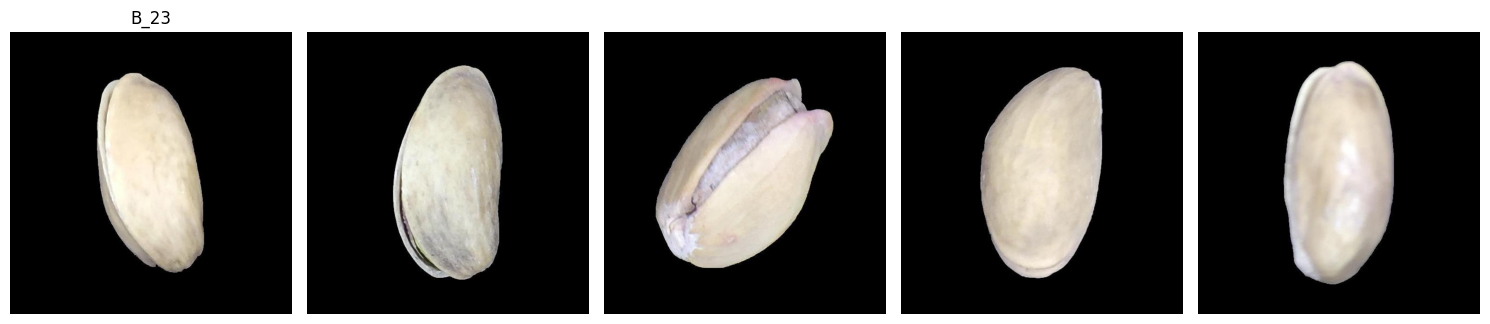

In [ ]:
num_samples_to_show = 5

plt.figure(figsize=(15, 8))

for i, folder in enumerate(class_folders):
    folder_path = os.path.join(IMAGE_DIR, folder)
    file_list = os.listdir(folder_path)

    # Ambil sampel file secara acak
    random_samples = random.sample(file_list, num_samples_to_show)

    for j, file_name in enumerate(random_samples):
        image_path = os.path.join(folder_path, file_name)

        # Buat subplot
        ax = plt.subplot(len(class_folders), num_samples_to_show, i * num_samples_to_show + j + 1)

        # Baca dan tampilkan gambar
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis("off")

        # Beri judul nama kelas di baris pertama
        if j == 0:
            plt.title(folder)

plt.tight_layout()
plt.show()

disini menampilkan 5 sampel acak dari kelas 'B_23'. ini memberi gambaran awal sebelum lanjut ke proses preprocessing dan modeling.

### Distribusi Warna

Total gambar yang ditemukan: 1074
Mengambil 20 sampel untuk dianalisa.


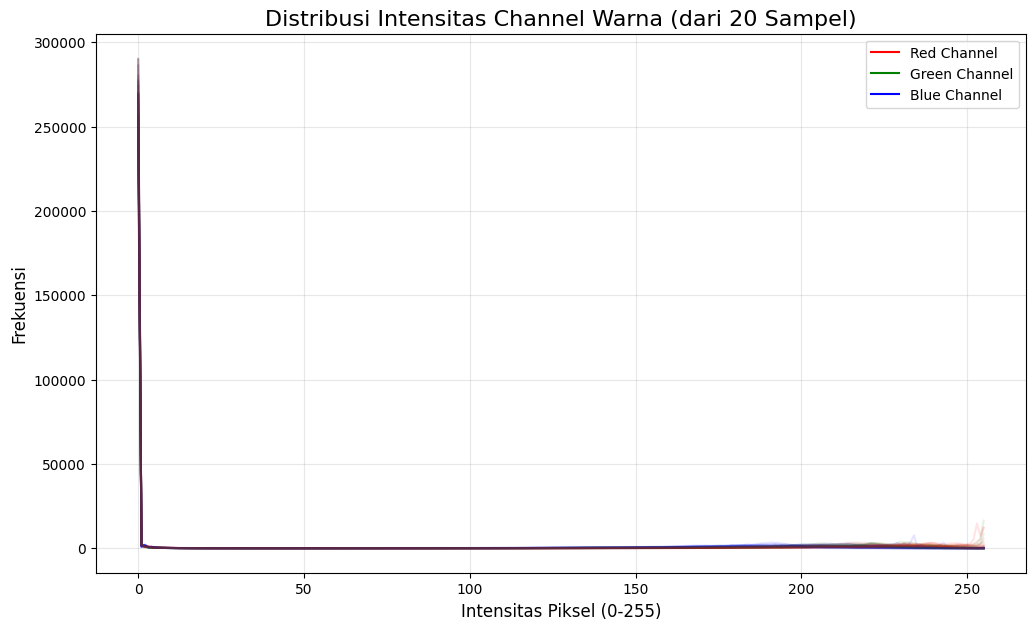

In [ ]:
colors = ('b', 'g', 'r')
num_samples = 20

try:
    all_image_paths = glob.glob(os.path.join(IMAGE_DIR, '**', '*.jpg'), recursive=True)
    if not all_image_paths:
        raise FileNotFoundError(f"Tidak ada file .jpg yang ditemukan di {IMAGE_DIR}")

    print(f"Total gambar yang ditemukan: {len(all_image_paths)}")

    sample_paths = np.random.choice(all_image_paths, min(num_samples, len(all_image_paths)), replace=False)
    print(f"Mengambil {len(sample_paths)} sampel untuk dianalisa.")

    plt.figure(figsize=(12, 7))
    plt.title(f'Distribusi Intensitas Channel Warna (dari {len(sample_paths)} Sampel)', fontsize=16)
    plt.xlabel('Intensitas Piksel (0-255)', fontsize=12)
    plt.ylabel('Frekuensi', fontsize=12)

    for img_path in sample_paths:
        img = cv2.imread(img_path)
        if img is not None:
            for i, color in enumerate(colors):
                hist = cv2.calcHist([img], [i], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.1)

    plt.plot([], [], color='r', label='Red Channel')
    plt.plot([], [], color='g', label='Green Channel')
    plt.plot([], [], color='b', label='Blue Channel')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"Terjadi error tak terduga: {e}")

**Distribusi Intensitas Channel Warna (dari 20 Sampel)**   
Plot histogram ini sangatlah bagus dan sangat konsisten, dengan frekuensi yang tinggi di dekat nilai 0, itu menandakan latar belakang **hitam** yang dominan di setiap gambar.   
Kemudian untuk bagian RGB (Red Green Blue) sangat tumpang tindih yang menandakan **keseimbangan warna yang sangat baik dan natural**.  
Data ini sudah cukup ideal untuk di train tanpa perlu melakukan koreksi warna ataupun pencahayaan.

### t-SNE

Mengambil 500 gambar sebagai sampel untuk t-SNE.

Memuat model pre-trained untuk ekstraksi fitur...


/tmp/ipython-input-103-3801126204.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


Mengekstrak fitur dari gambar (proses ini mungkin butuh beberapa saat)...

Menjalankan t-SNE... Ini mungkin memakan waktu beberapa menit.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 4.637758
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.798157
[t-SNE] KL divergence after 1000 iterations: 1.267319

Membuat plot visualisasi...


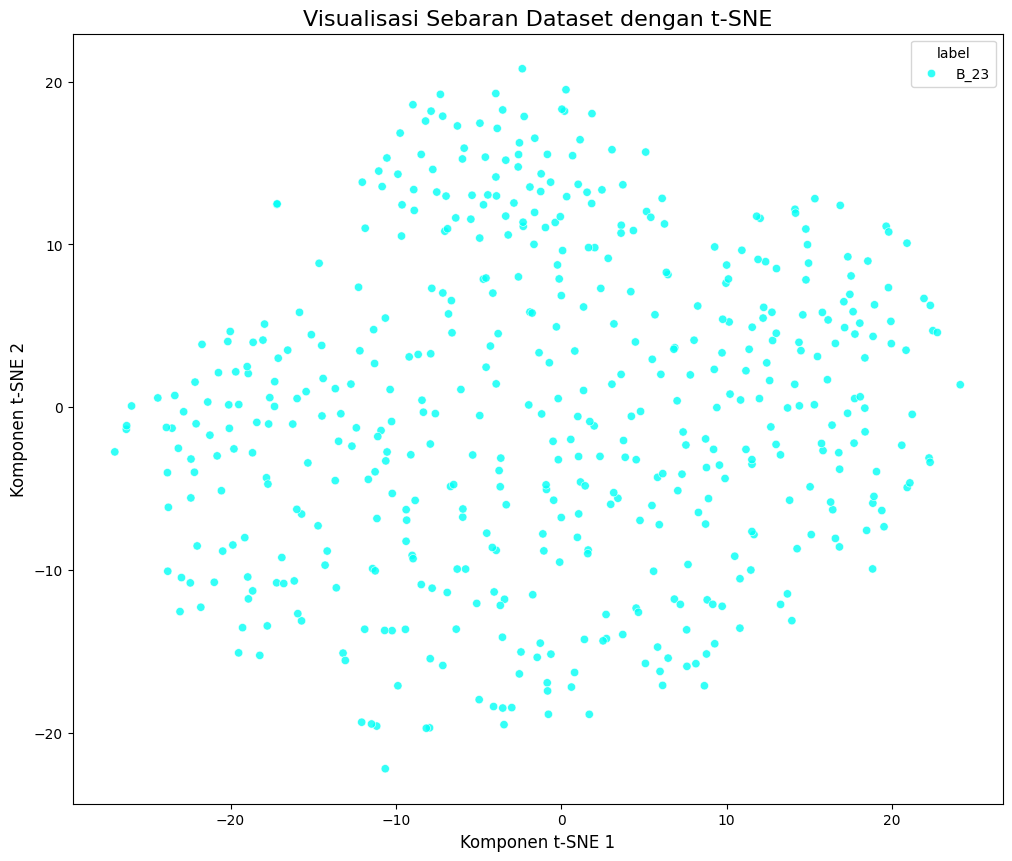

In [ ]:
try:
    all_image_paths = glob.glob(os.path.join(IMAGE_DIR, '**', '*.jpg'), recursive=True)
    if not all_image_paths:
        raise FileNotFoundError(f"Tidak ada file .jpg yang ditemukan di {IMAGE_DIR}")

    num_samples = min(len(all_image_paths), 500)
    sample_paths_tsne = np.random.choice(all_image_paths, num_samples, replace=False)
    print(f"Mengambil {len(sample_paths_tsne)} gambar sebagai sampel untuk t-SNE.")

    print("\nMemuat model pre-trained untuk ekstraksi fitur...")
    feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

    features = []
    print("Mengekstrak fitur dari gambar (proses ini mungkin butuh beberapa saat)...")
    for img_path in sample_paths_tsne:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)

        feature = feature_extractor.predict(preprocessed_img, verbose=0)
        features.append(feature.flatten())

    features = np.array(features)

    print("\nMenjalankan t-SNE... Ini mungkin memakan waktu beberapa menit.")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, max_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(features)

    df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])

    labels = [os.path.basename(os.path.dirname(p)) for p in sample_paths_tsne]
    df_tsne['label'] = labels

    print("\nMembuat plot visualisasi...")
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="label",
        palette=sns.color_palette("hsv", len(df_tsne['label'].unique())),
        data=df_tsne,
        legend="full",
        alpha=0.8
    )
    plt.title('Visualisasi Sebaran Dataset dengan t-SNE', fontsize=16)
    plt.xlabel('Komponen t-SNE 1', fontsize=12)
    plt.ylabel('Komponen t-SNE 2', fontsize=12)
    plt.show()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"Terjadi error tak terduga: {e}")

**Visualisasi Sebaran Dataset dengan t-SNE**  
Dari plot ini dapat kita pastikan bahwa datasetnya sangat bagus, bersih, dan juga konsisten.  
Dengan adanya gumpalan besar itu menunjukkan hasil yang **normal**.  
Luasnya sebaran titik yang ada pada gumpalan itu menunjukkan variasi yang bagus.  
Dengan tidak adanya titik yang terisolasi jauh, menandakan **dataset tidak ada outlier**.  


## Pre-processing

### Hyperparameter

In [ ]:
IMAGE_DIR = '/content/dataset/B_23'
IMG_HEIGHT = 100
IMG_WIDTH = 100
CHANNELS = 3
BATCH_SIZE = 8
BUFFER_SIZE = 800
NOISE_VARIANCE = 0.1
NOISE_TYPE = 'gaussian'
NOISE_MEAN = 0.0
NOISE_STDDEV = 0.1

ini untuk mendefinisikan hyperparameter yang dipake di projek ini

### Preprocessing Noise

In [ ]:
# A more efficient, pure-TensorFlow preprocessing function
def preprocess_image_and_add_noise_tf(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=CHANNELS, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    # Add noise using TensorFlow operations
    # BENAR: Menggunakan variabel yang sudah didefinisikan di hyperparameter
    noise = tf.random.normal(shape=tf.shape(img),
                         mean=NOISE_MEAN,
                         stddev=NOISE_STDDEV,
                         dtype=tf.float32)
    noisy_img = img + noise
    noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0)

    # Ensure shape is set correctly for the dataset pipeline
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    noisy_img.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])

    return noisy_img, img

code ini tugasnya untuk mengubah satu path gambar menjadi sepasang data yang siap di train oleh model. Dengan itu, saat training, dapat memberikan model gambar yang rusak dan menyuruhnya untuk belajar untuk menghasilkan gambar yang bersih.

### Image

In [ ]:
os.makedirs(IMAGE_DIR, exist_ok=True)
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in os.listdir(IMAGE_DIR) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_paths)} images in '{IMAGE_DIR}'")

Found 1074 images in '/content/dataset/B_23'


ini untuk cek isi gambar di datasetnya

## Splitting

In [ ]:
train_val_paths, test_paths = train_test_split(
    image_paths,
    test_size=0.10,
    random_state=42
)

train_paths, val_paths = train_test_split(
    train_val_paths,
    test_size=1/9,
    random_state=42
)

Code ini untuk membagi total dataset menjadi 3 bagian:  
* **Training Set**: Untuk melatih model.
* **Validation Set**: Untuk memantau performa model selama training.
* **Testing Set**: Untuk menguji performa dinal model pada data yang benar benar baru.  

Hasil akhir pembagian datasetnya menjadi:  
* **Training**: 80%  
* **Validation**: 10%  
* **Testing**: 10%  

In [ ]:
print(f"Number of training images: {len(train_paths)}")
print(f"Number of validation images: {len(val_paths)}")
print(f"Number of test images: {len(test_paths)}")

Number of training images: 858
Number of validation images: 108
Number of test images: 108


ini merupakan hasil dari pembagian datasetnya

### Noise


--- Visualisasi Data Input dan Target ---


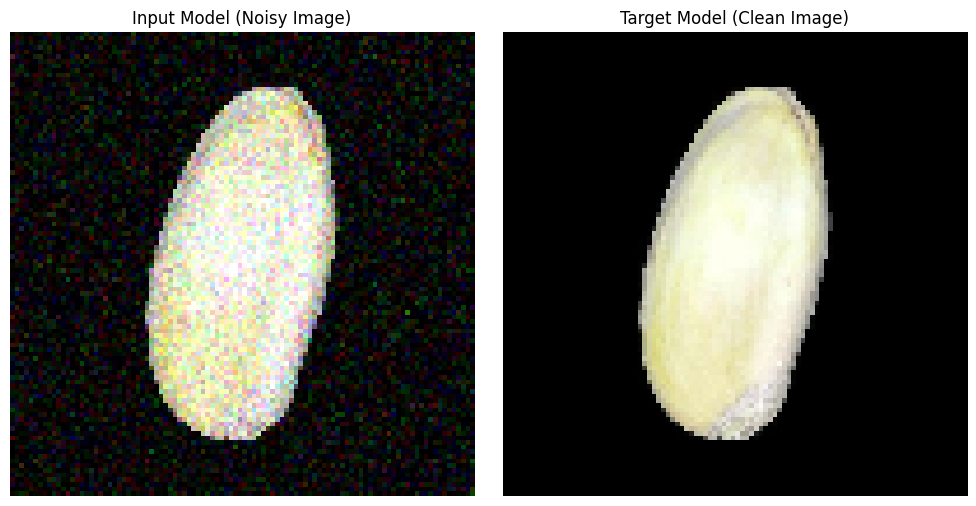

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(preprocess_image_and_add_noise_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Plot untuk verifikasi data pipeline
print("\n--- Visualisasi Data Input dan Target ---")
plt.figure(figsize=(10, 5))
for noisy_images, clean_images in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        # Plot Noisy Image (Input Model)
        ax = plt.subplot(1, 2, 1)
        plt.imshow(noisy_images[i])
        plt.title("Input Model (Noisy Image)")
        plt.axis("off")

        # Plot Clean Image (Target/Label Model)
        ax = plt.subplot(1, 2, 2)
        plt.imshow(clean_images[i])
        plt.title("Target Model (Clean Image)")
        plt.axis("off")
plt.tight_layout()
plt.show()

Visualisasi ini untuk membuktikan bahwa untuk setiap input gambar telat diberi noise, dan akan belajar untuk menghasilkan gambar asli yang bersih sebagai targetnya.

### Path

In [ ]:
# Finalisasi pipeline data untuk semua split
BUFFER_SIZE = len(train_paths)

# Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(preprocess_image_and_add_noise_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Validation Dataset
val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(preprocess_image_and_add_noise_tf, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Test Dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(preprocess_image_and_add_noise_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("✅ Semua data pipeline siap digunakan!")

✅ Semua data pipeline siap digunakan!


Code ini untuk mengubah daftar path gambar menjadi data yang siap di train. Untuk setiap path, pipeline ini secara otomatis memproses menjadi sepadang data, yaitu ***gambar noisy*** sebagai input dan ***gambar bersih*** sebagai target. Dan hanya untuk data training, disini menerapkan *shuffle* untuk mengacak urutan data, sebelum akhirnya mengelompokkan semuanya ke dalam *batch*.

## Modeling

### Base Model

In [ ]:
def build_specified_autoencoder(input_shape):

    inputs = Input(shape=input_shape)

    # ----------------- ENCODER -----------------
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # ----------------- DECODER -----------------

    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs, name="specified_autoencoder")
    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
autoencoder_model = build_specified_autoencoder(input_shape)

print("--- Arsitektur Model Base ---")
autoencoder_model.summary()

--- Arsitektur Model Base ---


Model: "specified_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

**Arsitektur Model Base**  
* **Output Shape**: ini menunjukkan alur data yang mengecil dibagian encoder dan kemudian membesar dibagian decoder, hal itu membuktikan autoencodernya sudah benar.
* **Param #**: ini merupakan bobot yang bisa di train setiap lapisannya. Layer yang memiliki 0 parameter karena hanya melakukan operasi, bukan belajar.
* **Total params (75,651)**: Angka ini menunjukkan bahwa model ini termasuk cepat untuk dilatih.  

In [ ]:
print("\n--- Compiling Model ---")
autoencoder_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
print("✅ Model compiled successfully with Adam optimizer and MSE loss.")


--- Compiling Model ---
✅ Model compiled successfully with Adam optimizer and MSE loss.


ini proses training dengan menetapkan algoritma *Adam* sebagai cara untuk belajar dan *MSE* sebagai metrik untuk mengukur tingkat kesalahannya.

In [ ]:
print("\n--- Starting Model Training ---")
EPOCHS = 100
history = autoencoder_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)
print("✅ Model training finished.")


--- Starting Model Training ---
Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0594 - val_loss: 0.0035
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 1

* Model ini akan melihat semua train dataset sebanyak 100 epochs.
* setiap epoch menampilkan performa *loss* dan juga *val_loss*.
* Output ini menunjukkan keberhasilakn karena *loss* dan *val_loss* nya terus menurun dengan signifikan, yang bersrti model ini berhasil belajar dengan baik.


--- Plotting Training History ---


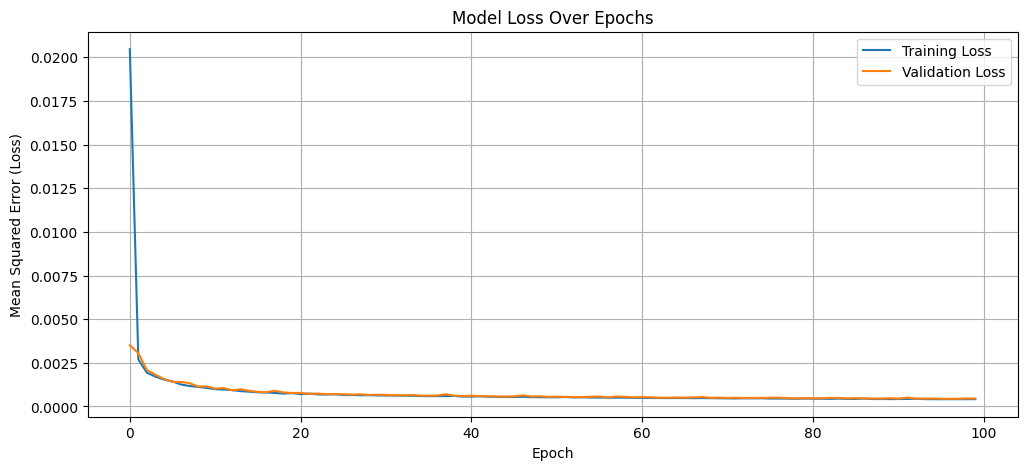

In [ ]:
print("\n--- Plotting Training History ---")
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

**Base Model Loss Over Epochs**  
* Kurva *Training* dan *Validation* turun dengan drastis yang artinya model belajar dengan cepat.
* Kurva *Training* dan *Validation* sangat berdekatan, itu merupakan tanda yang baik karena artinya *tidak ada overfitting*.
* Model yang dihasilkan sangat stabil dan bisa diandalkan untuk digunakan pada tahap evaluasi akhir dengan **test_dataset**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


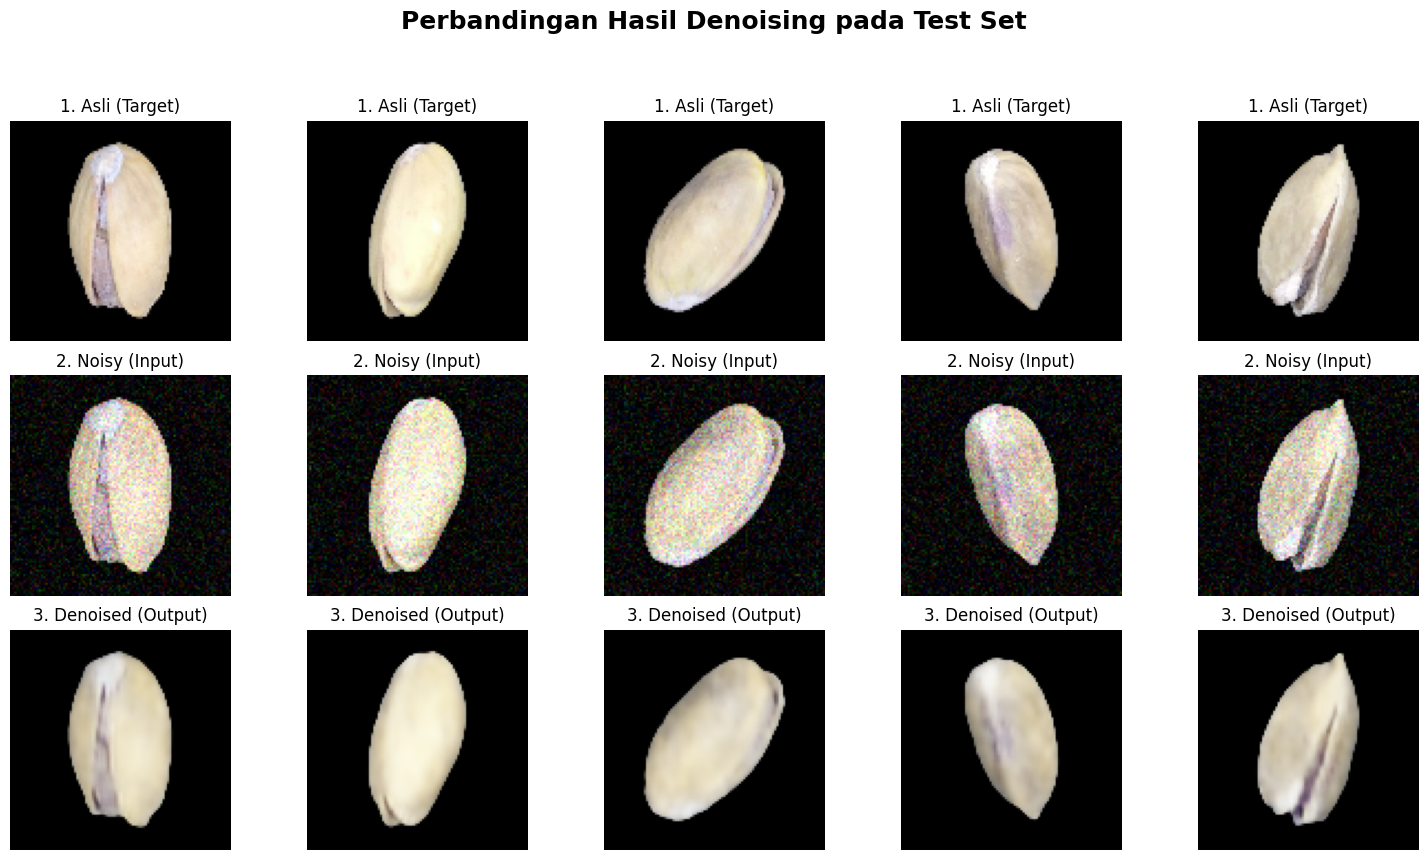

In [ ]:
# Definisi fungsi untuk visualisasi
def visualize_denoising_results(model, dataset, num_examples=5):
    for noisy_batch, original_batch in dataset.take(1):

        denoised_batch = model.predict(noisy_batch)

        num_to_show = min(num_examples, noisy_batch.shape[0])

        plt.figure(figsize=(3 * num_to_show, 9))
        plt.suptitle("Perbandingan Hasil Denoising pada Test Set", fontsize=18, fontweight='bold')

        for i in range(num_to_show):
            ax = plt.subplot(3, num_to_show, i + 1)
            plt.imshow(np.clip(original_batch[i], 0, 1))
            ax.set_title("1. Asli (Target)")
            ax.axis("off")

            ax = plt.subplot(3, num_to_show, i + 1 + num_to_show)
            plt.imshow(np.clip(noisy_batch[i], 0, 1))
            ax.set_title("2. Noisy (Input)")
            ax.axis("off")

            ax = plt.subplot(3, num_to_show, i + 1 + 2 * num_to_show)
            plt.imshow(np.clip(denoised_batch[i], 0, 1))
            ax.set_title("3. Denoised (Output)")
            ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.94])
        plt.show()

        break


visualize_denoising_results(autoencoder_model, test_dataset, num_examples=5)

**Perbandingan Hasil Denoising pada Test Set**
* Model sangat efektif menghilangkan hampir semua noise, berhasil mengubah gambar yang rusak menjadi bersih.
* Bentuk dan orientasi object direkonstruksi dengan akurat, dimana hasi output sangat cocok dengan gambar asli.
* Hasilnya mungkin terlihat sedikit lebih halus atau *blur*. ini adalah trade off yang normal terjadi saat autoencoder membuang noise frekuensi tinggi.
* Warna warna kunci pada objek dan latar belakang hitam berhasil direproduksi kembali dengan baik.
* Model ini terbukti solid dengan mampu membedakan mana fitur penting dari objek dan mana noise.

### SSIM Base Model

In [ ]:
def calculate_average_ssim(model, dataset):

    print(f"Mengevaluasi SSIM untuk model: {model.name}...")
    ssim_scores = []

    for noisy_batch, original_batch in dataset:
        reconstructed_batch = model.predict(noisy_batch, verbose=0)

        ssim_val = tf.image.ssim(original_batch, reconstructed_batch, max_val=1.0)

        ssim_scores.extend(ssim_val.numpy())

    return np.mean(ssim_scores)


print("\nMemulai proses kalkulasi SSIM untuk model baseline...")

ssim_score_baseline = calculate_average_ssim(autoencoder_model, test_dataset)

print("\n--- Hasil Evaluasi Kuantitatif ---")
print(f"Skor Rata-rata SSIM untuk Model Baseline: {ssim_score_baseline:.4f}")
print("------------------------------------")


Memulai proses kalkulasi SSIM untuk model baseline...
Mengevaluasi SSIM untuk model: specified_autoencoder...

--- Hasil Evaluasi Kuantitatif ---
Skor Rata-rata SSIM untuk Model Baseline: 0.9623
------------------------------------


**SSIM**  (0.9623)
* Skor sangat tinggi dan mendekati 1.0 (sempurna), yang secara kuantitatif membuktikan model baseline ini sudah sangat bagus dan merekonstruksi gambar.  
* ini membuktikan bahwa *bentuk dan struktur utama* objek berhasil dipertahankan dengan sangat akurat setelah noise dihilangkan.  
* Angka ini adalah **benchmark** yang solid.

### U-net

In [ ]:
def build_unet_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # --- ENCODER ---
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1) # 50x50

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2) # 25x25

    # --- BOTTLENECK ---
    bottleneck = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # --- DECODER ---
    up1 = UpSampling2D((2, 2))(bottleneck)
    concat1 = Concatenate()([up1, conv2])
    dec_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(dec_conv1)
    concat2 = Concatenate()([up2, conv1])
    dec_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(dec_conv2)

    model = Model(inputs, outputs, name="unet_autoencoder")
    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

unet_model = build_unet_autoencoder(input_shape)

print("--- Arsitektur Model U-Net ---")
unet_model.summary()

--- Arsitektur Model U-Net ---


Model: "unet_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 100, 100,  │        896 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 50, 50,    │          0 │ conv2d_69[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 25, 25,    │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 25, 25,    │     73,856 │ max_pooling2d_25… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_24    │ (None, 50, 50,    │          0 │ conv2d_71[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 50, 50,    │          0 │ up_sampling2d_24… │
│ (Concatenate)       │ 192)              │            │ conv2d_70[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 50, 50,    │    110,656 │ concatenate_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_25    │ (None, 100, 100,  │          0 │ conv2d_72[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 100, 100,  │          0 │ up_sampling2d_25… │
│ (Concatenate)       │ 96)               │            │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 100, 100,  │     27,680 │ concatenate_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 100, 100,  │        867 │ conv2d_73[0][0]   │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,451 (908.01 KB)

 Trainable params: 232,451 (908.01 KB)

 Non-trainable params: 0 (0.00 B)

**Arsitektur Model U-Net**  
* Kolom *Output Space* dengan jelas memperlihatkan alur data yang mengecil ke *bottleneck* lalu membesar lagi kembali ke ukuran semula, membentuk struktur 'U' yang khas.
* Layer *Concatenate* adalah kuncinya. Kolom *Connected to* dan jumlah channelnya secara visual membuktikan adanya "jembatan" yang berhasil menghubungkan fitur dari enccoder ke decoder.
* Dengan total kurang lebih **232 ribu** parameter, model ini sekitar 3x lebih besar dari model baseline. Itu memberikan kapasitar belajar yang jauh lebih tinggi untuk menghasilkan output yang lebih baik.

In [ ]:
LEARNING_RATE = 0.0005

# 3. Buat objek optimizer Adam dengan learning rate tersebut
adam_optimizer = Adam(learning_rate=LEARNING_RATE)

# 4. Compile model Anda dengan menggunakan objek optimizer yang baru
print("\n--- Compiling U-Net Model with Custom Learning Rate ---")
unet_model.compile(optimizer=adam_optimizer,  # <-- Menggunakan objek, bukan string
                   loss='mean_squared_error')

print(f"✅ Model U-Net berhasil di-compile dengan learning rate: {LEARNING_RATE}")


--- Compiling U-Net Model with Custom Learning Rate ---
✅ Model U-Net berhasil di-compile dengan learning rate: 0.0005


ini proses training dengan mempersiapkan *unet_model* untuk dilatih dengan cara membuat optimizer **Adam** secara manual yang memiliki kecepatan belajar (*learning rate*) spesifik sebesar **0.0005**.

In [ ]:
print("\n--- Memulai Proses Training Model U-Net ---")
EPOCHS = 100

history_unet = unet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

print("✅ Proses training model U-Net selesai.")


--- Memulai Proses Training Model U-Net ---
Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0581 - val_loss: 0.0021
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.9180e-04 - val_loss: 8.5233e-04
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.6773e-04 - val_loss: 6.4982e-04
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.8855e-04 - val_loss: 5.9158e-04
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.8972e-04 - val_loss: 5.5182e-04
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.2549e-04 - val_loss: 4.8755e-04
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.0742e-04 - val_loss: 4.6139e-04
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.7512e-04 - val_loss: 4.4936e-04
Epoch 11/100
108/1

**Proses Training Model U-Net**  
* Nilai *loss* dan *val_loss* turun drastis di awal. Ini menunjukkan modelnya sangat efektif dalam mempelajari tugasnya untuk membersihkan noise.
* Kedua nilai *loss* tersebut **nilainya sangat berdeketan** itu merupakan tanda tidak adanya overfitting dan model mampu menggeneralisasi dengan baik.
* Semua indikator menunjukkan training berjalan lancar.


--- Plotting Riwayat Training U-Net ---


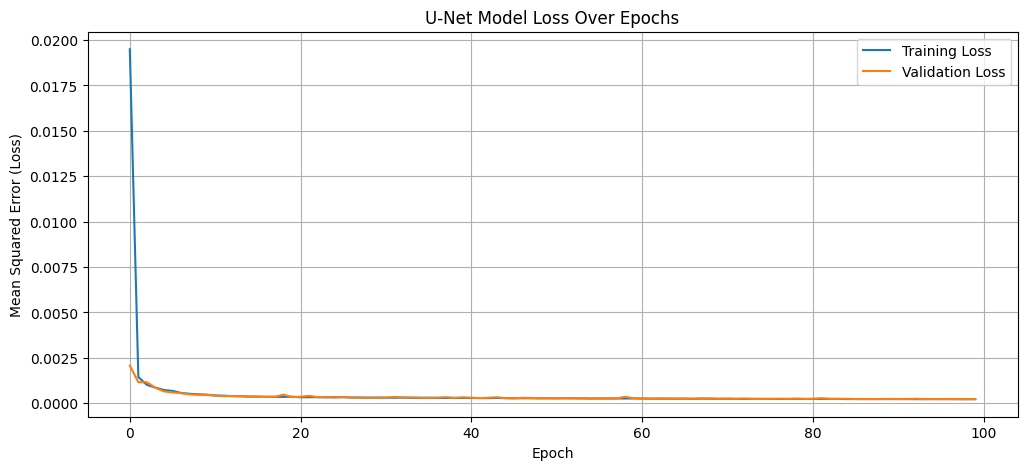

In [ ]:
print("\n--- Plotting Riwayat Training U-Net ---")
plt.figure(figsize=(12, 5))
plt.plot(history_unet.history['loss'], label='Training Loss')
plt.plot(history_unet.history['val_loss'], label='Validation Loss')
plt.title('U-Net Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

 **U-Net Model Loss Over Epochs**  
 * Kurva *Training Loss* dan *Validation Loss* **hampir menempel sempurna**. Ini adalah tanda terbaik bahwa model ini sangat baik dalam menggeneralisasi dan tidak hanya menghafal.  
 * Model belajar sangat cepat dibawah, kemudian mencapai performa puncaknya dan menjadi stabil.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


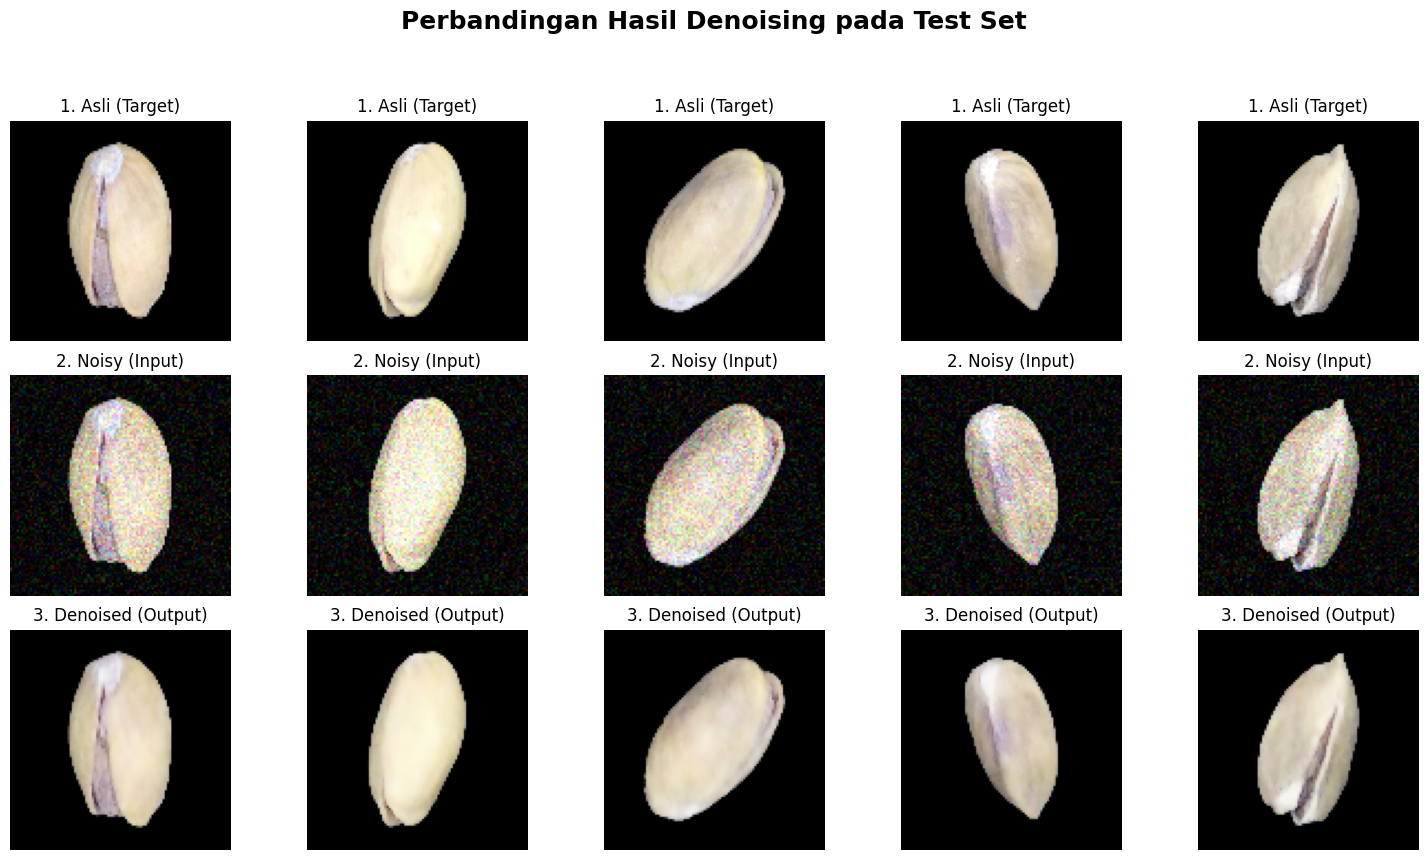

In [ ]:
# Definisi fungsi untuk visualisasi
def visualize_denoising_results(model, dataset, num_examples=5):
    for noisy_batch, original_batch in dataset.take(1):

        denoised_batch = model.predict(noisy_batch)

        num_to_show = min(num_examples, noisy_batch.shape[0])

        plt.figure(figsize=(3 * num_to_show, 9))
        plt.suptitle("Perbandingan Hasil Denoising pada Test Set", fontsize=18, fontweight='bold')

        for i in range(num_to_show):
            ax = plt.subplot(3, num_to_show, i + 1)
            plt.imshow(np.clip(original_batch[i], 0, 1))
            ax.set_title("1. Asli (Target)")
            ax.axis("off")

            ax = plt.subplot(3, num_to_show, i + 1 + num_to_show)
            plt.imshow(np.clip(noisy_batch[i], 0, 1))
            ax.set_title("2. Noisy (Input)")
            ax.axis("off")

            ax = plt.subplot(3, num_to_show, i + 1 + 2 * num_to_show)
            plt.imshow(np.clip(denoised_batch[i], 0, 1))
            ax.set_title("3. Denoised (Output)")
            ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.94])
        plt.show()

        break


visualize_denoising_results(unet_model, test_dataset, num_examples=5)

**Perbandingan Hasil Denoising pada Test Set**  
* Hasil rekonstruksi dari U-Net secara signifikan **lebih tajam dan kaya akan tekstur** dibandingkan hasil model baseline. Efek blur yang sebelumnya ada kini jauh berkurang.
* Peningkatan detail ini adalah bukti langsung bahwa **"jembatan" atau *skip connection*** pada arsitektur U_Net berhasil mempertahankan informasi penting yang sebelumnya hilang pada model baseline.  
* Secara visual, U-Net adalah pemenangnya.

### SSIM U-net

In [ ]:
def calculate_average_ssim(model, dataset):

    print(f"Mengevaluasi SSIM untuk model: {model.name}...")
    ssim_scores = []

    for noisy_batch, original_batch in dataset:
        reconstructed_batch = model.predict(noisy_batch, verbose=0)

        ssim_val = tf.image.ssim(original_batch, reconstructed_batch, max_val=1.0)

        ssim_scores.extend(ssim_val.numpy())

    return np.mean(ssim_scores)


print("\nMemulai proses kalkulasi SSIM untuk model modifikasi...")

ssim_score_modifikasi = calculate_average_ssim(unet_model, test_dataset)

print("\n--- Hasil Evaluasi Kuantitatif ---")
print(f"Skor Rata-rata SSIM untuk Model Modifikasi: {ssim_score_modifikasi:.4f}")
print("------------------------------------")


Memulai proses kalkulasi SSIM untuk model modifikasi...
Mengevaluasi SSIM untuk model: unet_autoencoder...

--- Hasil Evaluasi Kuantitatif ---
Skor Rata-rata SSIM untuk Model Modifikasi: 0.9718
------------------------------------


**SSIM** (0.9718)  
* Skor yang sangat mendekati 1.0 ini secara kuantitatif membuktikan bahwa gambar hasil rekonstruksi dari model U-Net **sangat mirip secara struktural** dengan gambar aslinya yang bersih.  
* Model ini tidak hanya berhasil menghilangkan noise, tetapi juga mampu **mempertahankan detail-deatil penting** seperti bentuk, serta struktur halus dari objek dengan sangat akurat.  
* Performa ini hasil langsung dari arsitektur U-Net yang baik, dimana mekanisme ***skip connections*** berhasil membantu decoder merekonstruksi gambar dengan ketajaman yang jauh lebih baik dari autoencoder biasa.

## Model Base Line vs U-Net Model

* **Perbandingan Berdasarkan Angka**  
  * Model U-Net secara angka **terbukti lebih unggul** dari model baseline.
    * **Skor SSIM** lebih tinggi: **0.9718** (U-Net) vs 0.9623 (Baseline).  
    * **Final Validatioin Loss** lebih rendah: **~0.0002** (U-Net) vs ~0.0004 (Baseline).  
  * Peningkatan performa ini dicapai meskipun U-Net memiliki model yang lebih kompleks **(~232 ribu parameter)** dibandingkan baseline (~75 ribu parameter).

* **Perbandingan Berdasarkan Visual**  
  * Meskipun kedua model berhasil menghilangkan noise dengan baik, hasil visual dari U-Net **secara kasar mata lebih superior**
    * Hasil **U-Net** terlihat **lebih tajam dan kaya akan detail tekstur**, dengan goresan goresan halus pada objek lebih terjaga.
    * Hasil **Baseline** cenderung **sedikit** **lebih** **halus** **atau** ***blur***, di mana beberapa detail tekstur hilang.

* **Analisa Penyebab Keunggulan**  
  * Kunci utama keunggulan performa Model U-Net terletak pada **arsitektur *skip connections*** (koneksi pintas) yang digunakannya.
  * *Skip connections* ini bertindak seperti "jembatan" yang menyalurkan kembali informasi detail spasial dari lapisan encoder ke decoder, mencegah detail tersebut hilang di bagian *bottleneck* seperti yang terjadi pada model baseline.

* **Kesimpulan Akhir**
  * Eksperimen ini secara komprehensif **berhasil membuktikan** bahwa modifikasi arsitektur dari autoencoder standar ke arsitektur U-Net memberikan **peningkatan performa yang signifikan dan terukur**.
  * Model U-Net menang baik secara **kuantitatif** (angka SSIM dan loss) maupun **kualitatif** (hasil gambar lebih bagus), menjadikannya model yang lebih superior untuk tugas *image denoising* pada dataset ini.